In [1]:
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
os.environ['DDE_BACKEND'] = 'tensorflow'

In [2]:
import deepxde as dde 
import tensorflow as tf 
import numpy as np
import matplotlib.pyplot as plt

2023-10-08 14:28:04.044228: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-08 14:28:04.044313: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-08 14:28:04.044349: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-08 14:28:04.053844: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends

Enable just-in-time compilation with XLA.



In [6]:
E = 50
nu = 0.3
a = 10
b = 10
f = 1
h = 1

In [23]:
color_legend = [[0, 0.182], [-0.06, 0.011], [-0.0022, 1.0], [-0.15, 0.45]]
title = ['x-displacement ($u$)', 'y-displacement ($v$)', '$\sigma_{xx}$', '$\sigma_{yy}$']

In [34]:
diag_x = np.arange(100, -1, -1)/10

In [38]:
diag_x

array([10. ,  9.9,  9.8,  9.7,  9.6,  9.5,  9.4,  9.3,  9.2,  9.1,  9. ,
        8.9,  8.8,  8.7,  8.6,  8.5,  8.4,  8.3,  8.2,  8.1,  8. ,  7.9,
        7.8,  7.7,  7.6,  7.5,  7.4,  7.3,  7.2,  7.1,  7. ,  6.9,  6.8,
        6.7,  6.6,  6.5,  6.4,  6.3,  6.2,  6.1,  6. ,  5.9,  5.8,  5.7,
        5.6,  5.5,  5.4,  5.3,  5.2,  5.1,  5. ,  4.9,  4.8,  4.7,  4.6,
        4.5,  4.4,  4.3,  4.2,  4.1,  4. ,  3.9,  3.8,  3.7,  3.6,  3.5,
        3.4,  3.3,  3.2,  3.1,  3. ,  2.9,  2.8,  2.7,  2.6,  2.5,  2.4,
        2.3,  2.2,  2.1,  2. ,  1.9,  1.8,  1.7,  1.6,  1.5,  1.4,  1.3,
        1.2,  1.1,  1. ,  0.9,  0.8,  0.7,  0.6,  0.5,  0.4,  0.3,  0.2,
        0.1,  0. ])

In [37]:
diag_x[::-1]

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

In [39]:
def draw_result(location, result):
    plt.figure(figsize=(10, 8))
    for idx in range(4):
        plt.subplot(2, 2, idx+1)
        plt.scatter(location[:, 0], location[:, 1], c=result[:, idx], cmap='rainbow', s=5)
        plt.plot(diag_x, diag_x[::-1], '--', c='k', linewidth=2)
        plt.clim(color_legend[idx])
        plt.title(title[idx])
        plt.xlabel('x (mm)', fontsize = 14)
        plt.ylabel('y (mm)', fontsize = 14)
        plt.axis('square')
        plt.xlim([0, a])
        plt.ylim([0, b])
        plt.colorbar()
    plt.tight_layout()
    plt.show()

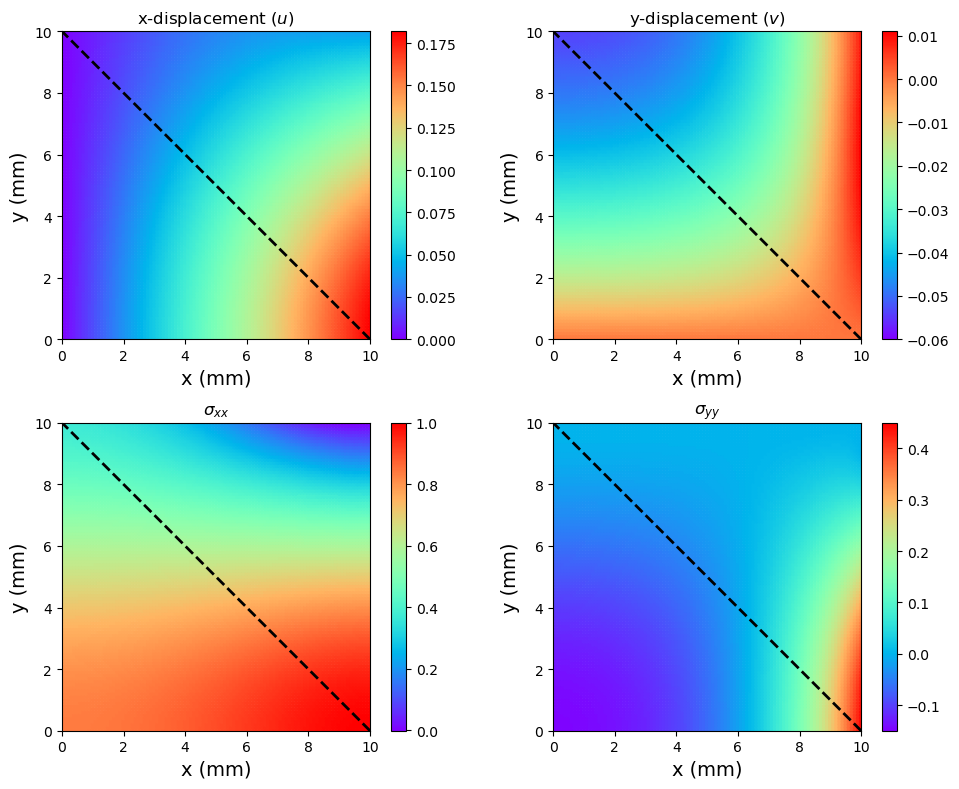

In [40]:
Plate_data = np.load('../Plate_data.npy')

loc = Plate_data[:, 0:2]

u = Plate_data[:, 2:3]
v = Plate_data[:, 3:4]

true_disp = np.hstack([u, v])
stress = Plate_data[:, 4:6]

true_result = np.hstack([true_disp, stress])

draw_result(loc, true_result)

In [41]:
def check_stress(net, X):
    X = tf.constant(X)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        disp = net(X)
        u_pred = tf.reshape(disp[:, 0], [-1, 1])
        v_pred = tf.reshape(disp[:, 1], [-1, 1])
    
    du_X = tape.gradient(u_pred, X)
    dv_X = tape.gradient(v_pred, X)

    du_x, du_y = du_X[:, 0], du_X[:, 1]
    dv_x, dv_y = dv_X[:, 0], dv_X[:, 1]

    sig_xx = tf.reshape( (du_x + nu*dv_y)*E/(1-nu**2), [-1, 1] )
    sig_yy = tf.reshape( (dv_y + nu*du_x)*E/(1-nu**2), [-1, 1] )
    
    return sig_xx, sig_yy

In [61]:
geom = dde.geometry.Rectangle(xmin=[0, 0], xmax=[a, b])
samples = geom.uniform_points(10201)

layer_size = [2] + [64] * 5 + [2]
activation = 'tanh'
initializer = 'Glorot uniform'
net = dde.maps.FNN(layer_size, activation, initializer)

Compiling model...
'compile' took 0.001177 s



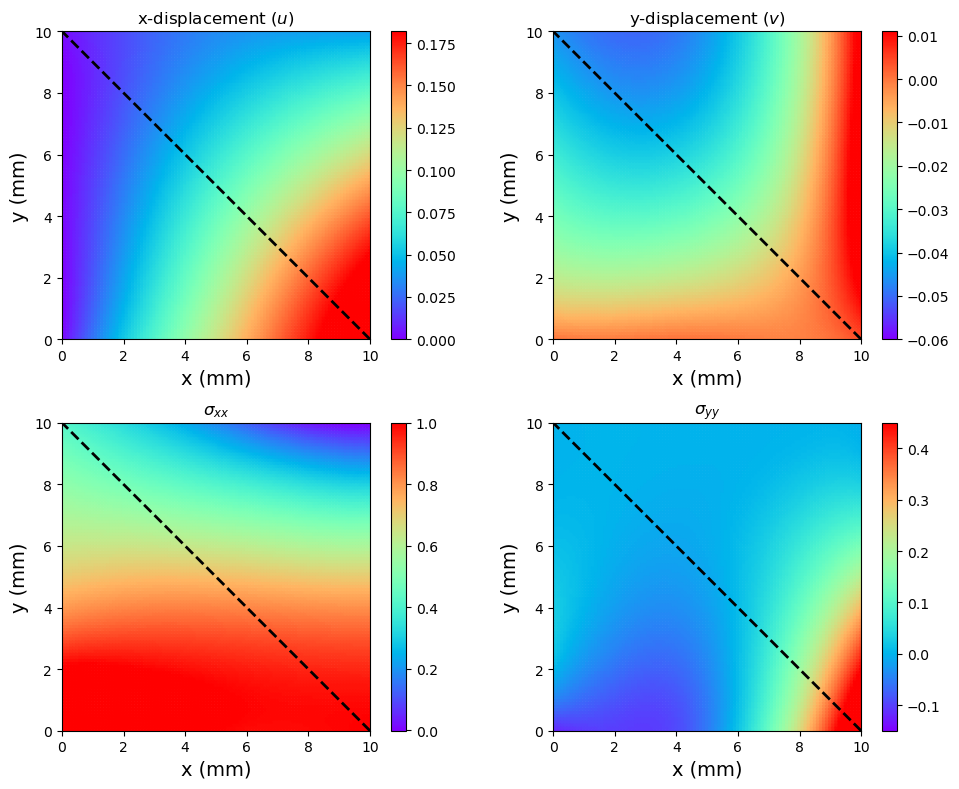

In [62]:
model = dde.Model(None, net)
model.restore('model/pde-12422.ckpt')
model.compile('L-BFGS')
pde_disp = model.predict(samples)
pde_sg = np.hstack(check_stress(model.net, samples))
pde_result = np.hstack([pde_disp, pde_sg])

draw_result(samples, pde_result)

Compiling model...
'compile' took 0.000804 s



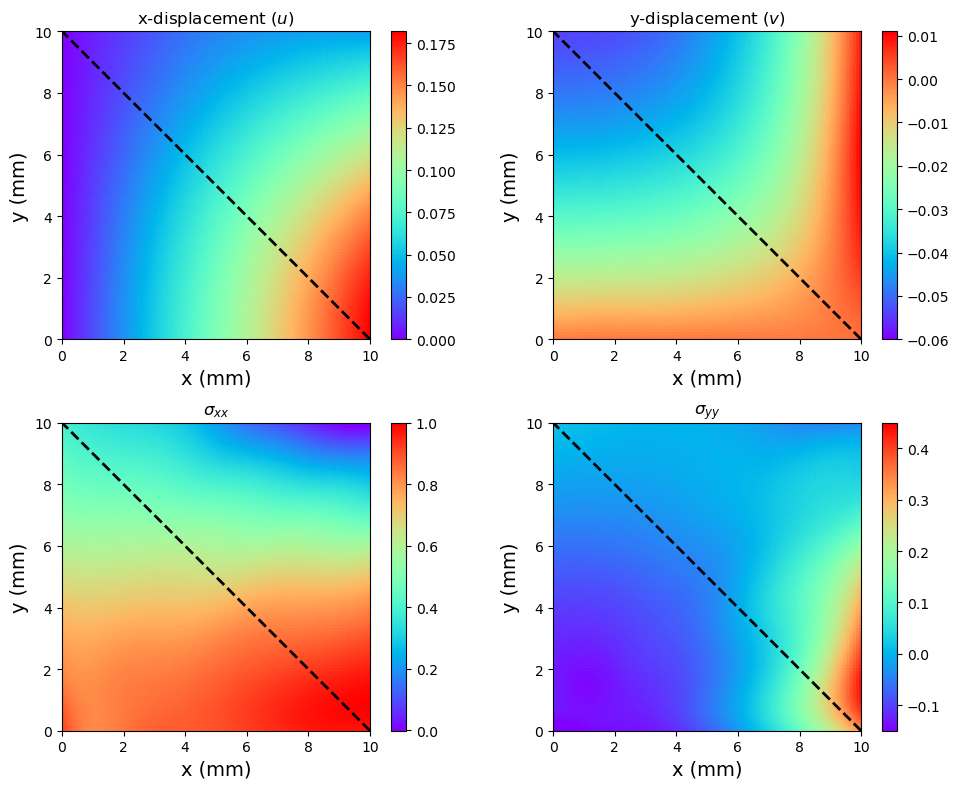

In [63]:
model = dde.Model(None, net)
model.restore('model/big-10603.ckpt')
model.compile('L-BFGS')
big_disp = model.predict(samples)
big_sg = np.hstack(check_stress(model.net, samples))
big_result = np.hstack([big_disp, big_sg])

draw_result(samples, big_result)

Compiling model...
'compile' took 0.000833 s



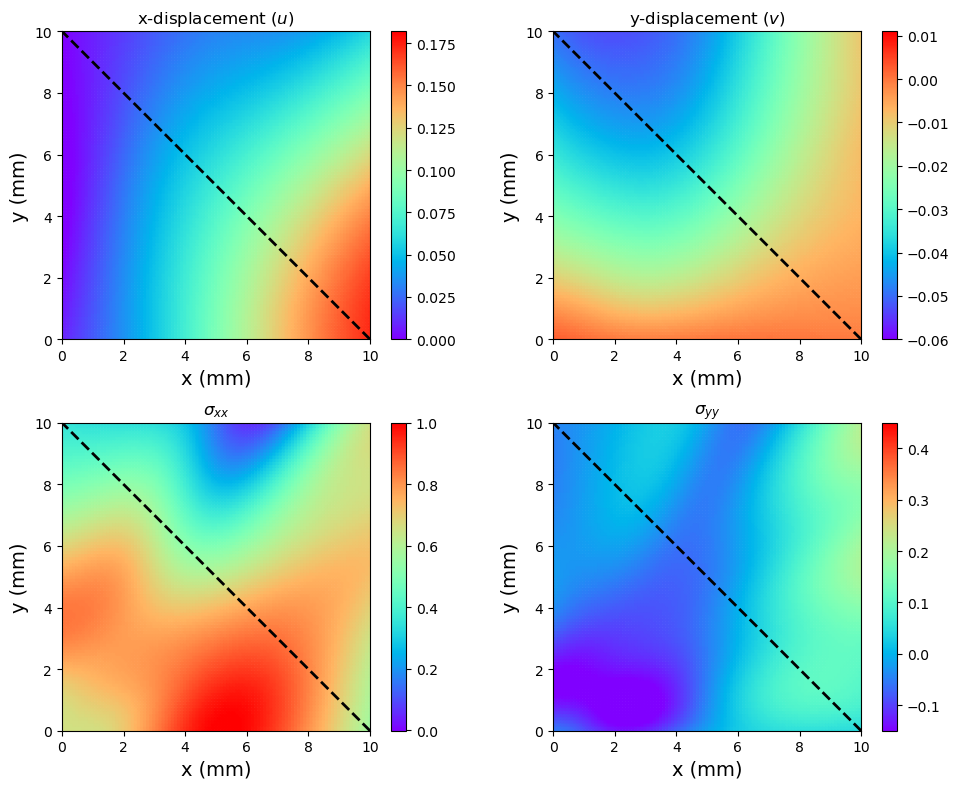

In [64]:
model = dde.Model(None, net)
model.restore('model/small-10122.ckpt')
model.compile('L-BFGS')
small_disp = model.predict(samples)
small_sg = np.hstack(check_stress(model.net, samples))
small_result = np.hstack([small_disp, small_sg])

draw_result(samples, small_result)

Compiling model...
'compile' took 0.001134 s



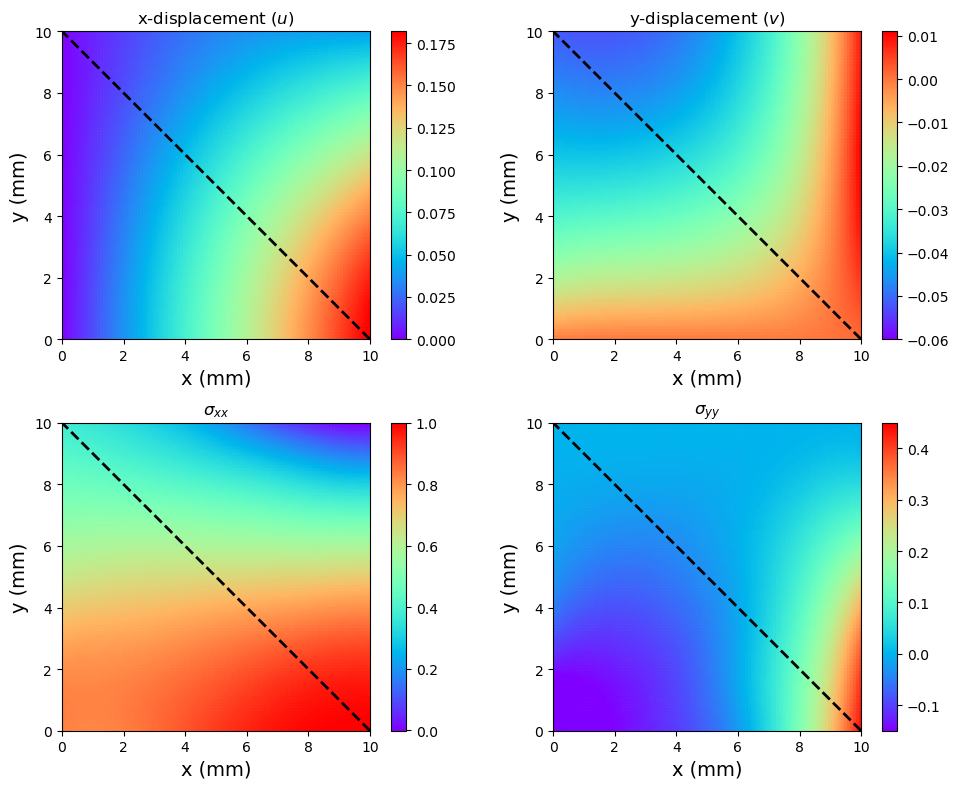

In [65]:
model = dde.Model(None, net)
model.restore('model/pde_small-11727.ckpt')
model.compile('L-BFGS')
pde_small_disp = model.predict(samples)
pde_small_sg = np.hstack(check_stress(model.net, samples))
pde_small_result = np.hstack([pde_small_disp, pde_small_sg])

draw_result(samples, pde_small_result)

In [66]:
diag_ = [i for i in range(u.shape[0]) if loc[i, 0] + loc[i, 1] == 10]
diag_

[100,
 200,
 300,
 400,
 500,
 600,
 700,
 800,
 900,
 1000,
 1100,
 1200,
 1300,
 1400,
 1500,
 1600,
 1700,
 1800,
 1900,
 2000,
 2100,
 2200,
 2300,
 2400,
 2500,
 2600,
 2700,
 2800,
 2900,
 3000,
 3100,
 3200,
 3300,
 3400,
 3500,
 3600,
 3700,
 3800,
 3900,
 4000,
 4100,
 4200,
 4300,
 4400,
 4500,
 4600,
 4700,
 4800,
 4900,
 5000,
 5100,
 5200,
 5300,
 5400,
 5500,
 5600,
 5700,
 5800,
 5900,
 6000,
 6100,
 6200,
 6300,
 6400,
 6500,
 6600,
 6700,
 6800,
 6900,
 7000,
 7100,
 7200,
 7300,
 7400,
 7500,
 7600,
 7700,
 7800,
 7900,
 8000,
 8100,
 8200,
 8300,
 8400,
 8500,
 8600,
 8700,
 8800,
 8900,
 9000,
 9100,
 9200,
 9300,
 9400,
 9500,
 9600,
 9700,
 9800,
 9900,
 10000,
 10100]

In [67]:
loc[diag_]

array([[ 0. , 10. ],
       [ 0.1,  9.9],
       [ 0.2,  9.8],
       [ 0.3,  9.7],
       [ 0.4,  9.6],
       [ 0.5,  9.5],
       [ 0.6,  9.4],
       [ 0.7,  9.3],
       [ 0.8,  9.2],
       [ 0.9,  9.1],
       [ 1. ,  9. ],
       [ 1.1,  8.9],
       [ 1.2,  8.8],
       [ 1.3,  8.7],
       [ 1.4,  8.6],
       [ 1.5,  8.5],
       [ 1.6,  8.4],
       [ 1.7,  8.3],
       [ 1.8,  8.2],
       [ 1.9,  8.1],
       [ 2. ,  8. ],
       [ 2.1,  7.9],
       [ 2.2,  7.8],
       [ 2.3,  7.7],
       [ 2.4,  7.6],
       [ 2.5,  7.5],
       [ 2.6,  7.4],
       [ 2.7,  7.3],
       [ 2.8,  7.2],
       [ 2.9,  7.1],
       [ 3. ,  7. ],
       [ 3.1,  6.9],
       [ 3.2,  6.8],
       [ 3.3,  6.7],
       [ 3.4,  6.6],
       [ 3.5,  6.5],
       [ 3.6,  6.4],
       [ 3.7,  6.3],
       [ 3.8,  6.2],
       [ 3.9,  6.1],
       [ 4. ,  6. ],
       [ 4.1,  5.9],
       [ 4.2,  5.8],
       [ 4.3,  5.7],
       [ 4.4,  5.6],
       [ 4.5,  5.5],
       [ 4.6,  5.4],
       [ 4.7,

In [68]:
title

['x-displacement ($u$)',
 'y-displacement ($v$)',
 '$\\sigma_{xx}$',
 '$\\sigma_{yy}$']

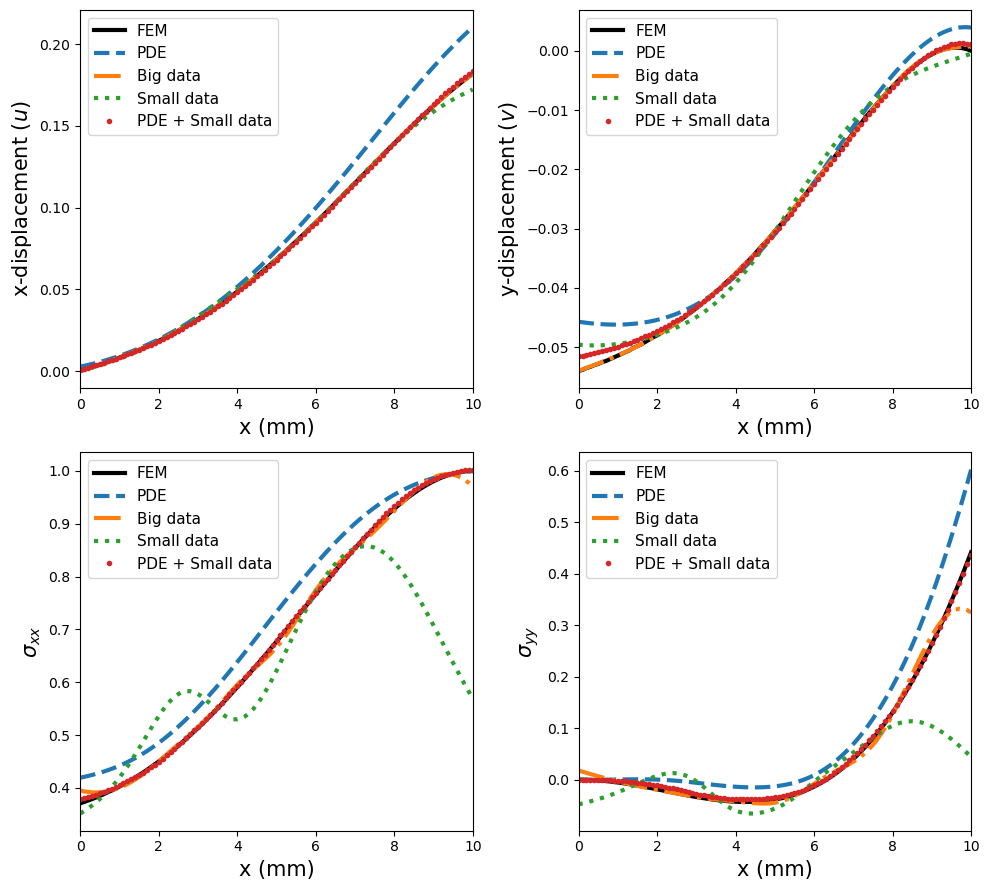

In [72]:
diag_result_true = [u[diag_], v[diag_], stress[diag_, 0], stress[diag_, 1]]
diag_result_pde = [pde_disp[diag_, 0], pde_disp[diag_, 1], pde_sg[diag_, 0], pde_sg[diag_, 1]]
diag_result_big = [big_disp[diag_, 0], big_disp[diag_, 1], big_sg[diag_, 0], big_sg[diag_, 1]]
diag_result_small = [small_disp[diag_, 0], small_disp[diag_, 1], small_sg[diag_, 0], small_sg[diag_, 1]]
diag_result_pde_small = [pde_small_disp[diag_, 0], pde_small_disp[diag_, 1], pde_small_sg[diag_, 0], pde_small_sg[diag_, 1]]

plt.figure(figsize=(10, 9))
for idx in range(4):
    plt.subplot(2, 2, idx+1)
    plt.plot(loc[diag_, 0], diag_result_true[idx], 'k', linewidth=3, label='FEM')
    plt.plot(loc[diag_, 0], diag_result_pde[idx], '--', linewidth=3, label='PDE')
    plt.plot(loc[diag_, 0], diag_result_big[idx], '-.', linewidth=3, label='Big data')
    plt.plot(loc[diag_, 0], diag_result_small[idx], ':', linewidth=3, label='Small data')
    plt.plot(loc[diag_, 0], diag_result_pde_small[idx], '.', linewidth=3, label='PDE + Small data')
    plt.xlabel('x (mm)', fontsize=15)
    plt.ylabel(title[idx], fontsize=15)
    plt.xlim([0, a])
    plt.legend(fontsize=11)

plt.tight_layout()
plt.show()